# VENDEE GLOBE  

_C'est pas l'homme qui prend la mer, c'est la mer qui prend l'homme, TINTINTIN_ - un anonyme homonyme d'un constructeur automobile national  

Aujourd'hui nous allons nous poser une question similaire : est-ce le marin qui porte le bateau, ou le bateau qui porte le marin ?

En utilisant les données du classement du Vendée Globe de l'an passé, ainsi que les données liées aux navires de ces marins, nous tenterons de voir dans quelle mesure les caractéristiques des vaisseaux ont affecté la performance des participants.

# OBTENTION DES DONNEES

In [1]:
"""from datetime import datetime,timedelta
import requests
import random

date = datetime.strptime("20201108",'%Y%m%d').date()
final_date = datetime.strptime("20210305",'%Y%m%d').date()
addoneday = timedelta(days=1)

times = list()
for time in ["04", "08", "11", "14", "17", "21"]: 
    times.append(datetime.strptime(time,"%H").time())

while date <= final_date:
    for time in times:
        x = datetime.combine(date, time).strftime('%Y%m%d_%H%M%S')
        url = f"https://www.vendeeglobe.org/download-race-data/vendeeglobe_{x}.xlsx"
        try:
            r = requests.get(url, allow_redirects=True)
            if r.status_code==200:
                open(f"data/{x}.xlsx", "wb").write(r.content)
        except:
            continue
    date += addoneday"""

'from datetime import datetime,timedelta\nimport requests\nimport random\n\ndate = datetime.strptime("20201108",\'%Y%m%d\').date()\nfinal_date = datetime.strptime("20210305",\'%Y%m%d\').date()\naddoneday = timedelta(days=1)\n\ntimes = list()\nfor time in ["04", "08", "11", "14", "17", "21"]: \n    times.append(datetime.strptime(time,"%H").time())\n\nwhile date <= final_date:\n    for time in times:\n        x = datetime.combine(date, time).strftime(\'%Y%m%d_%H%M%S\')\n        url = f"https://www.vendeeglobe.org/download-race-data/vendeeglobe_{x}.xlsx"\n        try:\n            r = requests.get(url, allow_redirects=True)\n            if r.status_code==200:\n                open(f"data/{x}.xlsx", "wb").write(r.content)\n        except:\n            continue\n    date += addoneday'

In [2]:
"""import glob
import xlwings

def xlsx_broken(file):
    excel_app = xlwings.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save()
    excel_book.close()
    excel_app.quit()
    return True

for f in glob.glob("./data/*"):
    xlsx_broken(f)"""

'import glob\nimport xlwings\n\ndef xlsx_broken(file):\n    excel_app = xlwings.App(visible=False)\n    excel_book = excel_app.books.open(file)\n    excel_book.save()\n    excel_book.close()\n    excel_app.quit()\n    return True\n\nfor f in glob.glob("./data/*"):\n    xlsx_broken(f)'

# NETTOYAGE ET SCRAPING DES DONNEES DES BATEAUX

In [3]:
import pandas as pd
import re
import numpy as np
import glob
from datetime import datetime
import os
import requests
from bs4 import BeautifulSoup

pd.options.display.max_columns=25

#https://stackoverflow.com/questions/33997361
def dms2dd(s):
    try:
        degrees, minutes, direction = re.split('[°\'"]+', s)
        dd = float(degrees) + float(minutes)/60
        if direction in ('S','W'):
            dd*= -1
        return dd
    except:
        return s

def opendf(file):
    df = pd.read_excel(file, header=[0,1], skiprows=3, nrows=33)
    df = df.dropna(axis=1, how="all")
    df.columns = [re.sub(r'\W+', '', \
                  ' '.join([x.split("\n")[0] if x.split("\n")[0] and "Unnamed" not in x else "" if "Unnamed" in x else x for x in y]) \
                  .strip()) \
                  for y in df.columns.values]
    df[["Nat", "Voile"]] = df["NatVoile"].str.split(" ", expand=True)
    df["Nat"] = df["Nat"].str.split("\n").apply(lambda x: x[1] if isinstance(x,list) else x) #Sacrée Armel
    df[["Skipper", "Bateau"]] = df["SkipperBateau"].str.split("\n", expand=True)
    df["Bateau"] = df["Bateau"].str.lower() #Hugo Boss s'énerve à mi-chemin
    df["SkipperBateauHeureFR"] = df["SkipperBateauHeureFR"].str.split(" ").apply(lambda x: x[0] if isinstance(x,list) else x)
    for col in df.columns:
        df[col] = df[col].str.strip()
    df["Voile"] = df["Voile"].astype(int)
    df["DateTime"] = datetime.strptime(os.path.basename(file).split(".")[-2].split("/")[-1], '%Y%m%d_%H%M%S')
    splitto = lambda x: x.split()[0] if isinstance(x,str) else x
    df["DTF_nm"] = df["DTF"].apply(splitto).astype(float)
    df["DTL_nm"] = df["DTL"].apply(splitto).astype(float)
    df["24h_dist_nm"] = df["Depuis24heuresDistance"].apply(splitto).astype(float)
    df["24h_vitesse_kts"] = df["Depuis24heuresVitesse"].apply(splitto).astype(float)
    df["24h_vmg_kts"] = df["Depuis24heuresVMG"].apply(splitto).astype(float)
    df["classement_dist_nm"] = df["DepuisledernierclassementDistance"].apply(splitto).astype(float)
    df["classement_vitesse_kts"] = df["DepuisledernierclassementVitesse"].apply(splitto).astype(float)
    df["classement_vmg_kts"] = df["DepuisledernierclassementVMG"].apply(splitto).astype(float)
    df["30min_dist_nm"] = df["Depuis30minutesDistance"].apply(splitto).astype(float)
    df["30min_vitesse_kts"] = df["Depuis30minutesVitesse"].apply(splitto).astype(float)
    df["30min_vmg_kts"] = df["Depuis30minutesVMG"].apply(splitto).astype(float)
    df["Latitude"] = df["SkipperBateauLatitude"].apply(dms2dd)
    df["Longitude"] = df["SkipperBateauLongitude"].apply(dms2dd)
    dropcols = ["DTF","DTL","Depuis24heuresDistance","Depuis24heuresVitesse","Depuis24heuresVMG",
                "Depuis30minutesDistance","Depuis30minutesVitesse","Depuis30minutesVMG",
                "DepuisledernierclassementDistance","DepuisledernierclassementVitesse","DepuisledernierclassementVMG",
                "SkipperBateauLatitude","SkipperBateauLongitude","SkipperBateau","NatVoile"]
    df = df.drop(dropcols, axis=1)
    return df

df = opendf("./data/20201108_140000.xlsx")
for f in glob.glob("./data/*"):
    try:
        df = df.append(opendf(f))
    except:
        continue

df.to_csv("./dataclean/vendeeglobe0.csv")

df.head()

,Rang,SkipperBateauHeureFR,Depuis30minutesCap,DepuisledernierclassementCap,Depuis24heuresCap,Nat,Voile,Skipper,Bateau,DateTime,DTF_nm,DTL_nm,24h_dist_nm,24h_vitesse_kts,24h_vmg_kts,classement_dist_nm,classement_vitesse_kts,classement_vmg_kts,30min_dist_nm,30min_vitesse_kts,30min_vmg_kts,Latitude,Longitude
0,1,15:30,241°,357°,201°,FRA,18,Louis Burton,bureau vallée 2,2020-11-08 14:00:00,24293.9,0.0,6.1,0.3,0.3,2788.0,0.0,0.0,0.3,17.7,17.5,46.407667,-1.841333
1,2,15:31,241°,357°,196°,MON,10,Boris Herrmann,seaexplorer - yacht club de monaco,2020-11-08 14:00:00,24294.2,0.4,6.0,0.3,0.2,2787.9,0.0,0.0,0.4,11.1,10.9,46.405667,-1.830333
2,3,15:30,244°,357°,199°,FRA,8,Jérémie Beyou,charal,2020-11-08 14:00:00,24294.3,0.5,5.5,0.2,0.2,2788.5,0.0,0.0,0.5,15.5,15.5,46.415167,-1.833167
3,4,15:30,244°,357°,196°,FRA,59,Thomas Ruyant,linkedout,2020-11-08 14:00:00,24294.5,0.6,5.6,0.2,0.2,2788.3,0.0,0.0,0.7,13.2,13.1,46.411833,-1.828000
4,5,15:30,246°,357°,195°,FRA,53,Maxime Sorel,v and b mayenne,2020-11-08 14:00:00,24294.5,0.6,5.8,0.8,0.7,2788.1,0.0,0.0,0.2,10.9,10.9,46.409833,-1.826000


In [4]:
soup = BeautifulSoup(requests.get("https://www.vendeeglobe.org/fr/glossaire").content.decode("utf-8"))

boats=list()
for boat in soup.find_all("div", {"class":"boats-list__popup-infos"}):
    dict_ = {"nom":boat.find("h3").text}
    for li in boat.find_all("li")[:-1]:
        dict_[li.text.split(":")[0].strip()] = li.text.split(":")[1].strip()
    boats.append(dict_)

df_boats = pd.DataFrame(boats)
for col in df_boats.columns:
    df_boats[col] = df_boats[col].str.lower()

dict_ = {"foiler":"foils","2":"no foils","2 asymétriques":"no foils","foils":"foils"}
df_boats["Foils"] = df_boats["Nombre de dérives"].map(dict_)
df_boats = df_boats.drop("Nombre de dérives",1)

df_boats["Voile quille"] = df_boats["Voile quille"].apply(lambda x: x.split()[0] if isinstance(x,str) else x)

df_boats["Numéro de voile"] = df_boats["Numéro de voile"].fillna(59) #valeur manquante dans le glossaire, on remplit d'après les excel

df_boats["Year_launched"] = df_boats["Date de lancement"].apply(lambda x: x[-4:])
df_boats["Year_launched"] = pd.to_datetime(df_boats["Year_launched"], format="%Y").dt.year
df_boats = df_boats.drop("Date de lancement",1)

numcols = ["Numéro de voile","Tirant d'eau","Déplacement (poids)","Longueur","Largeur","Surface de voiles au près", "Hauteur mât"]

for col in numcols:
    df_boats[col] = df_boats[col].apply(lambda x: re.sub("[a-z]+", "", str(x).lower()).strip().replace(",","."))

df_boats["Numéro de voile"] = df_boats["Numéro de voile"].astype(int).replace(16,10).replace(77,777) #on remplace d'après les excels

df_boats["Déplacement (poids)"] = df_boats["Déplacement (poids)"].apply(lambda x: np.nan if x == "" else x)
df_boats["Surface de voiles au près"] = df_boats["Surface de voiles au près"].apply(lambda x: x.split()[0])
df_boats[numcols] = df_boats[numcols].astype(float)

df_boats.to_csv("./dataclean/boats.csv")

df_boats.head()

,nom,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Voile quille,Surface de voiles au près,Foils,Year_launched
0,newrest - art & fenêtres,56.0,"no way back, vento di sardegna",vplp/verdier,persico marine,18.28,5.85,4.5,7.0,29.0,monotype,320.0,foils,2015
1,pure - best western®,49.0,"gitana eighty, synerciel, newrest-matmut",bruce farr design,southern ocean marine (nouvelle zélande),18.28,5.80,4.5,9.0,28.0,acier,280.0,no foils,2007
2,tse - 4myplanet,72.0,"famille mary-etamine du lys, initiatives coeur...",marc lombard,mag france,18.28,5.54,4.5,9.0,29.0,acier,260.0,no foils,1998
3,maître coq iv,17.0,safran 2 - des voiles et vous,verdier - vplp,cdk technologies,18.28,5.80,4.5,8.0,29.0,acier,310.0,foils,2015
4,charal,8.0,NaN,vplp,cdk technologies,18.28,5.85,4.5,8.0,29.0,acier,320.0,foils,2018


In [5]:
df["Date"] = df["DateTime"].dt.date #pour grouper et prendre la dernière
df["DateTime"] = df["DateTime"].astype(str) #plotly préfère les strings 
df = df[df["Rang"].str.isnumeric()] #élimination des skippers éliminés ou ayant abandonné
df["Rang"] = df["Rang"].astype(int) #pour visualisations

df_merged = df.merge(df_boats, left_on="Voile", right_on="Numéro de voile", how="left")
df_merged.to_csv("./dataclean/vendeewboats.csv")

df_merged.head()

,Rang,SkipperBateauHeureFR,Depuis30minutesCap,DepuisledernierclassementCap,Depuis24heuresCap,Nat,Voile,Skipper,Bateau,DateTime,DTF_nm,DTL_nm,...,Anciens noms du bateau,Architecte,Chantier,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Voile quille,Surface de voiles au près,Foils,Year_launched
0,1,15:30,241°,357°,201°,FRA,18,Louis Burton,bureau vallée 2,2020-11-08 14:00:00,24293.9,0.0,...,banque populaire viii,verdier - vplp,cdk technologies,18.28,5.80,4.5,7.6,28.0,acier,300.0,foils,2015
1,2,15:31,241°,357°,196°,MON,10,Boris Herrmann,seaexplorer - yacht club de monaco,2020-11-08 14:00:00,24294.2,0.4,...,"edmond de rothschild, malizia - yacht club de ...",verdier - vplp,multiplast,18.28,5.70,4.5,7.6,29.0,acier,290.0,foils,2015
2,3,15:30,244°,357°,199°,FRA,8,Jérémie Beyou,charal,2020-11-08 14:00:00,24294.3,0.5,...,NaN,vplp,cdk technologies,18.28,5.85,4.5,8.0,29.0,acier,320.0,foils,2018
3,4,15:30,244°,357°,196°,FRA,59,Thomas Ruyant,linkedout,2020-11-08 14:00:00,24294.5,0.6,...,NaN,verdier,persico,18.28,5.85,4.5,8.0,29.0,acier,350.0,foils,2019
4,5,15:30,246°,357°,195°,FRA,53,Maxime Sorel,v and b mayenne,2020-11-08 14:00:00,24294.5,0.6,...,"le souffle du nord, groupe bel",verdier - vplp,"indiana yachting (scarlino, italie)",18.28,5.50,4.5,7.7,29.0,acier,365.0,no foils,2007


In [6]:
#On crée un dataframe qui contient les rangs à l'arrivée
df_final = pd.read_excel("data/20210305_080000.xlsx",skiprows=3,nrows=33,header=[0,1])
df_final = df_final.dropna(axis=1, how="all")
df_final.columns = [re.sub(r'\W+', '', \
              ' '.join([x.split("\n")[0] if x.split("\n")[0] and "Unnamed" not in x else "" if "Unnamed" in x else x for x in y]) \
              .strip()) \
              for y in df_final.columns.values]
df_final["distfond/distortho"] = df_final[""]
df_final = df_final[df_final["Rang"] != "RET"]
df_final[["Nat", "Voile"]] = df_final["NatVoile"].str.split(" ", expand=True)
splitto = lambda x: x.split()[0] if x.split()[0] else np.nan
df_final["Rang_arrivée"] = df_final["Rang"].apply(splitto).astype(int)
df_final[["Skipper", "Bateau"]] = df_final["SkipperBateau"].str.split("\n", expand=True)
df_final["Bateau"] = df_final["Bateau"].str.lower()
df_final = df_final.drop(["NatVoile","","SkipperBateau","Datedarrivée","Tempsdecourse","ÉcartsAupremier","ÉcartsAuprécédent","Nat","Rang"],axis=1)
for col in [x for x in df_final.columns if "vitesse" in x.lower() or "dist" in x.lower()]:
    df_final[col] = df_final[col].apply(splitto)
df_final["Voile"] = df_final["Voile"].astype(int)
num_cols = ['SurlorthoVitesse', 'SurlorthoDistance', 'SurlefondVitesse', 'SurlefondDistance', 'distfond/distortho']
df_final[num_cols] = df_final[num_cols].apply(pd.to_numeric)
df_final = df_final.merge(df_boats, left_on="Voile", right_on="Numéro de voile", how="left")
print(df_final.columns)
df_final.to_csv("dataclean/vendeefinal.csv")
df_final.head()

Index(['SurlorthoVitesse', 'SurlorthoDistance', 'SurlefondVitesse',
       'SurlefondDistance', 'distfond/distortho', 'Voile', 'Rang_arrivée',
       'Skipper', 'Bateau', 'nom', 'Numéro de voile', 'Anciens noms du bateau',
       'Architecte', 'Chantier', 'Longueur', 'Largeur', 'Tirant d'eau',
       'Déplacement (poids)', 'Hauteur mât', 'Voile quille',
       'Surface de voiles au près', 'Foils', 'Year_launched'],
      dtype='object')


,SurlorthoVitesse,SurlorthoDistance,SurlefondVitesse,SurlefondDistance,distfond/distortho,Voile,Rang_arrivée,Skipper,Bateau,nom,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Voile quille,Surface de voiles au près,Foils,Year_launched
0,12.6,24365.7,14.8,28583.8,117.3,17,1,Yannick Bestaven,maître coq iv,maître coq iv,17.0,safran 2 - des voiles et vous,verdier - vplp,cdk technologies,18.28,5.80,4.5,8.0,29.0,acier,310.0,foils,2015
1,12.6,24365.7,15.1,29135.0,119.6,79,2,Charlie Dalin,apivia,apivia,79.0,NaN,verdier,cdk technologies - merconcept,18.28,5.85,4.5,8.0,29.0,acier,350.0,foils,2019
2,12.6,24365.7,14.8,28650.0,117.6,18,3,Louis Burton,bureau vallée 2,bureau vallee 2,18.0,banque populaire viii,verdier - vplp,cdk technologies,18.28,5.80,4.5,7.6,28.0,acier,300.0,foils,2015
3,12.5,24365.7,14.1,27501.5,112.9,1,4,Jean Le Cam,yes we cam !,yes we cam!,1.0,"cheminées poujoulat, mare, maître coq, mapfre,...",bruce farr design,cdk technologies,18.28,5.90,4.5,8.0,28.0,acier,300.0,no foils,2007
4,12.6,24365.7,14.7,28448.5,116.8,10,5,Boris Herrmann,seaexplorer - yacht club de monaco,seaexplorer - yacht club de monaco,10.0,"edmond de rothschild, malizia - yacht club de ...",verdier - vplp,multiplast,18.28,5.70,4.5,7.6,29.0,acier,290.0,foils,2015


# STATISTIQUES DESCRIPTIVES

In [7]:
print("Les 5 premiers skippers en vitesse moyenne jusqu'au 27 janvier :")
df_merged.groupby(["Skipper","Voile","Foils"])["classement_vitesse_kts"].mean()\
         .sort_values(ascending=False).to_frame().reset_index()\
         .merge(df_final[["Voile","Skipper","Rang_arrivée"]], left_on=["Voile","Skipper"], right_on=["Voile","Skipper"], how="left").head()

Les 5 premiers skippers en vitesse moyenne jusqu'au 27 janvier :


,Skipper,Voile,Foils,classement_vitesse_kts,Rang_arrivée
0,Charlie Dalin,79,foils,14.748730,2.0
1,Louis Burton,18,foils,14.723908,3.0
2,Thomas Ruyant,59,foils,14.647586,6.0
3,Yannick Bestaven,17,foils,14.571264,1.0
4,Boris Herrmann,10,foils,14.568736,5.0


In [8]:
print("Confirmation avec résultats finaux :")
df_final[["Voile","Skipper","SurlefondVitesse","Foils","Rang_arrivée"]].sort_values("SurlefondVitesse",ascending=False).head()

Confirmation avec résultats finaux :


,Voile,Skipper,SurlefondVitesse,Foils,Rang_arrivée
5,59,Thomas Ruyant,15.1,foils,6
1,79,Charlie Dalin,15.1,foils,2
0,17,Yannick Bestaven,14.8,foils,1
2,18,Louis Burton,14.8,foils,3
4,10,Boris Herrmann,14.7,foils,5


In [9]:
print("Les 5 premiers skippers en vitesse utile moyenne jusqu'au 27 janvier :")
df_merged.groupby(["Skipper","Voile","Foils"])["classement_vmg_kts"].mean()\
         .sort_values(ascending=False).to_frame().reset_index()\
         .merge(df_final[["Voile","Skipper","Rang_arrivée"]], left_on=["Voile","Skipper"], right_on=["Voile","Skipper"], how="left").head()

Les 5 premiers skippers en vitesse utile moyenne jusqu'au 27 janvier :


,Skipper,Voile,Foils,classement_vmg_kts,Rang_arrivée
0,Louis Burton,18,foils,13.012414,3.0
1,Boris Herrmann,10,foils,12.975172,5.0
2,Charlie Dalin,79,foils,12.969515,2.0
3,Giancarlo Pedote,34,foils,12.969425,8.0
4,Yannick Bestaven,17,foils,12.917701,1.0


In [10]:
print("Confirmation avec résultats finaux :")
df_final[["Voile","Skipper","SurlorthoVitesse","Foils","Rang_arrivée"]].sort_values("SurlorthoVitesse",ascending=False).head()

Confirmation avec résultats finaux :


,Voile,Skipper,SurlorthoVitesse,Foils,Rang_arrivée
0,17,Yannick Bestaven,12.6,foils,1
2,18,Louis Burton,12.6,foils,3
4,10,Boris Herrmann,12.6,foils,5
5,59,Thomas Ruyant,12.6,foils,6
1,79,Charlie Dalin,12.6,foils,2


In [11]:
print("5 premiers skippers en nombre de classements Rang 1 jusqu'au 27 janvier, avec indications foilers ou non :")
df_merged[df_merged["Rang"]==1].groupby(["Voile","Skipper","Foils"])["Rang"].count() \
                               .sort_values(ascending=False).to_frame().reset_index() \
                               .merge(df_final[["Voile","Skipper","Rang_arrivée"]], \
                                      left_on=["Voile","Skipper"], \
                                      right_on=["Voile","Skipper"], \
                                      how="left") \
                               .head()

5 premiers skippers en nombre de classements Rang 1 jusqu'au 27 janvier, avec indications foilers ou non :


,Voile,Skipper,Foils,Rang,Rang_arrivée
0,79,Charlie Dalin,foils,223,2.0
1,17,Yannick Bestaven,foils,157,1.0
2,99,Alex Thomson,foils,26,NaN
3,59,Thomas Ruyant,foils,20,6.0
4,18,Louis Burton,foils,8,3.0


In [12]:
print("Rang moyen à l'arrivée, foils/non-foils :")
df_final.groupby("Foils")["Rang_arrivée"].mean().to_frame()

Rang moyen à l'arrivée, foils/non-foils :


,Rang_arrivée
Foils,
foils,9.583333
no foils,16.153846


In [13]:
print("Distance moyenne parcourue sur le fond par type de foils :")
df_final.groupby("Foils")["SurlefondDistance"].mean().to_frame()

Distance moyenne parcourue sur le fond par type de foils :


,SurlefondDistance
Foils,
foils,28776.466667
no foils,27987.638462


In [14]:
print("Vitesse moyenne sur le fond à l'arrivée par type de foils :")
df_final.groupby("Foils")["SurlefondVitesse"].mean().to_frame()

Vitesse moyenne sur le fond à l'arrivée par type de foils :


,SurlefondVitesse
Foils,
foils,13.933333
no foils,12.484615


In [15]:
print("Vitesse moyenne sur l'ortho à l'arrivée par type de foils :")
df_final.groupby("Foils")["SurlorthoVitesse"].mean().to_frame()

Vitesse moyenne sur l'ortho à l'arrivée par type de foils :


,SurlorthoVitesse
Foils,
foils,11.791667
no foils,10.884615


La supériorité des foilers semble avérée après ces quelques statistiques.  
On remarque quand même une information significative : les foilers ont une distance moyenne parcourue sur le fond à l'arrivée bien supérieure à la distance moyenne parcourue sur le fond par les non-foilers...

# VISUALISATIONS

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot
import plotly.io as pio
pio.renderers.default = "vscode"

#Ce df va nous permettre de faire des visualisations plus légères avec plotly en réduisant le nombre de classements
df_grouped = df.groupby(["Date","Bateau"]).last()
df_grouped["Voile"] = df_grouped["Voile"].astype(int)
df_grouped = df_grouped.merge(df_boats, left_on="Voile", right_on="Numéro de voile", how="left")
df_grouped["Voile"] = df_grouped["Voile"].astype(str) #to use as categorical variable in visualizations
df_grouped.head()

,Rang,SkipperBateauHeureFR,Depuis30minutesCap,DepuisledernierclassementCap,Depuis24heuresCap,Nat,Voile,Skipper,DateTime,DTF_nm,DTL_nm,24h_dist_nm,...,Anciens noms du bateau,Architecte,Chantier,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Voile quille,Surface de voiles au près,Foils,Year_launched
0,2,18:30,266°,267°,257°,FRA,79,Charlie Dalin,2020-11-08 17:00:00,24235.6,0.6,66.8,...,NaN,verdier,cdk technologies - merconcept,18.28,5.85,4.5,8.0,29.0,acier,350.0,foils,2019
1,8,18:30,269°,267°,257°,FRA,4,Sébastien Simon,2020-11-08 17:00:00,24240.6,5.7,61.1,...,NaN,juan kouyoumdjian,cdk technologies / assemblage,18.28,5.70,4.5,8.0,29.0,inox,260.0,foils,2019
2,20,18:30,265°,263°,254°,FRA,30,Clarisse Cremer,2020-11-08 17:00:00,24246.9,12.0,53.5,...,macif - sma,verdier - vplp,cdk - mer agitée,18.28,5.70,4.5,7.7,29.0,acier,340.0,no foils,2011
3,11,18:30,271°,271°,262°,FRA,18,Louis Burton,2020-11-08 17:00:00,24241.7,6.8,62.4,...,banque populaire viii,verdier - vplp,cdk technologies,18.28,5.80,4.5,7.6,28.0,acier,300.0,foils,2015
4,25,18:30,253°,251°,244°,FRA,50,Miranda Merron,2020-11-08 17:00:00,24252.5,17.5,46.2,...,"great america iv, mirabaud, temenos",owen clarke,"southern ocean marine, tauranga",18.28,5.50,4.5,8.5,28.0,carbone,330.0,no foils,2006


## Les figures plotly sont enregistrées au format html dans le dossier "plots" et disponibles directement sous ce format

In [17]:
fig = px.scatter_geo(df_grouped, lat="Latitude", lon="Longitude", color="Voile", animation_frame="DateTime")
fig.write_html("plots/flat_animation.html")
plot(fig)
fig.show()

In [18]:
fig = px.scatter_geo(df_grouped, lat="Latitude", lon="Longitude", color="Voile", projection="orthographic", animation_frame="DateTime")
fig.write_html("plots/globe_animation.html")
plot(fig)
fig.show()

In [19]:
fig = px.scatter_geo(df_grouped, lat="Latitude", lon="Longitude", color="Foils", animation_frame="DateTime")
fig.write_html("plots/flat_animation_foils.html")
plot(fig)
fig.show()

In [20]:
fig = px.scatter_geo(df_grouped, lat="Latitude", lon="Longitude", color="Foils", projection="orthographic", animation_frame="DateTime")
fig.write_html("plots/globe_animation_foils.html")
plot(fig)
fig.show()

In [21]:
fig = px.line_geo(df_grouped, lat="Latitude", lon="Longitude", color="Voile")
fig.write_html("plots/flat_line.html")
plot(fig)
fig.show()

In [22]:
fig = px.line_geo(df_grouped, lat="Latitude", lon="Longitude", color="Voile", projection="orthographic")
fig.write_html("plots/globe_line.html")
plot(fig)
fig.show()

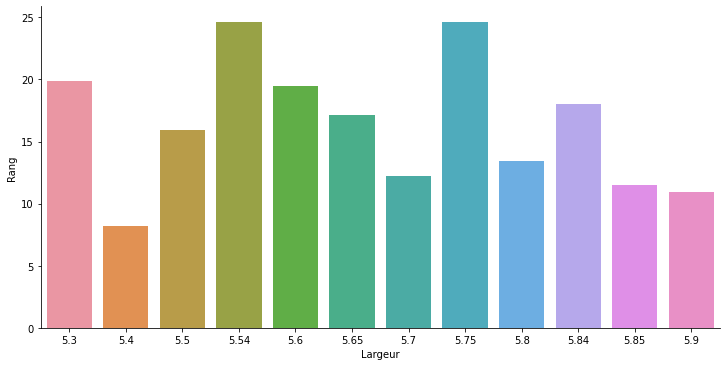

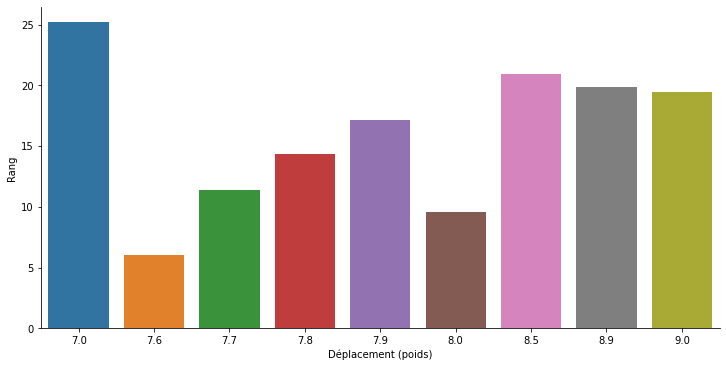

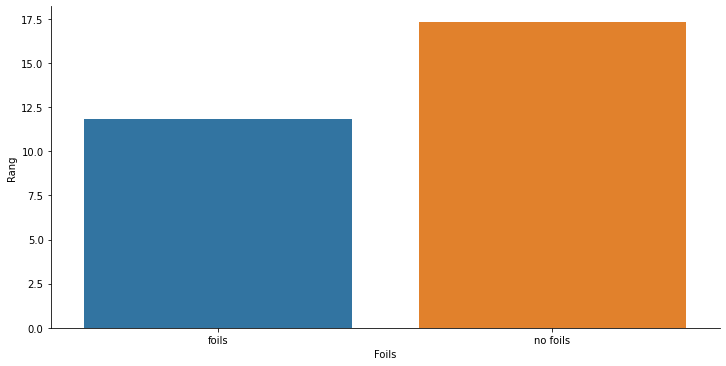

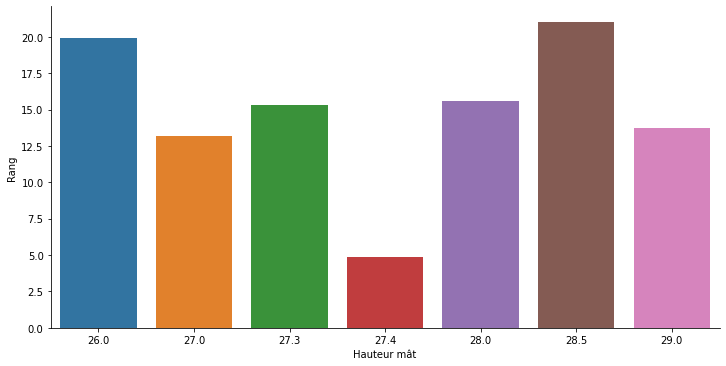

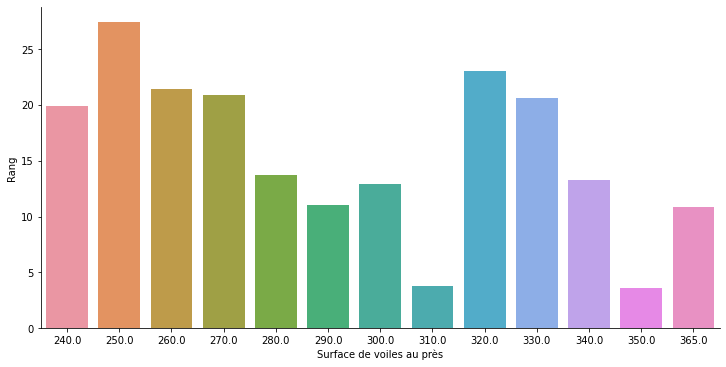

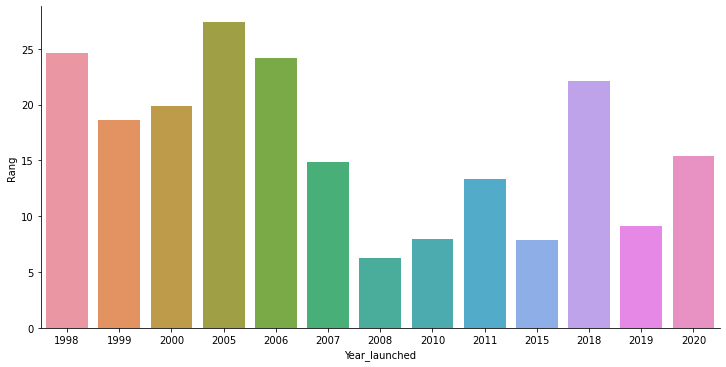

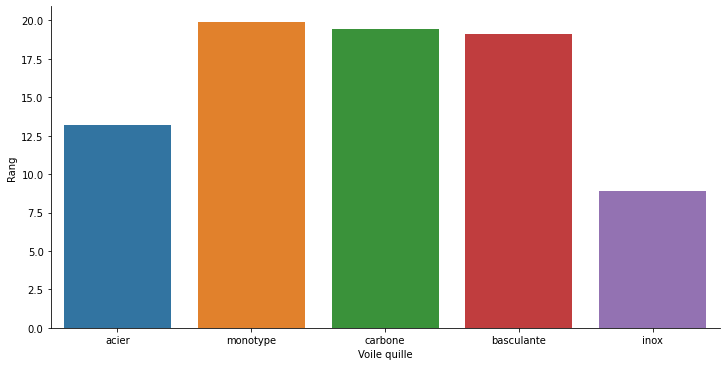

In [23]:
for col in ["Largeur","Déplacement (poids)","Foils","Hauteur mât","Surface de voiles au près","Year_launched","Voile quille"]:
    sns.catplot(data=df_merged, x=col, y="Rang", kind="bar", aspect=2, ci=None)
    plt.show()

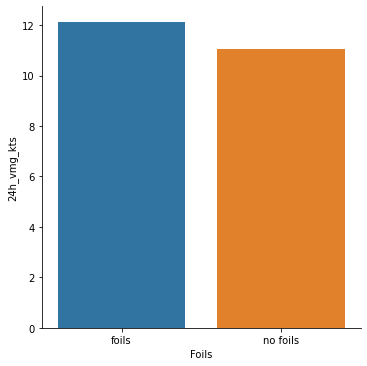

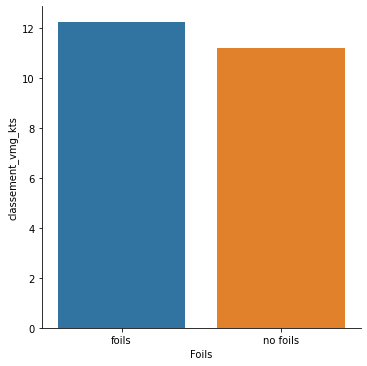

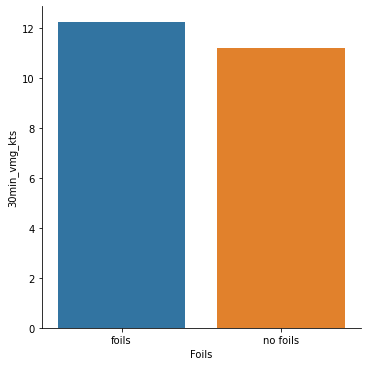

In [24]:
for col in [x for x in df_merged.columns if "vmg" in x]:
    sns.catplot(data=df_merged, x="Foils", y=col, kind="bar", ci=None)
    plt.show()

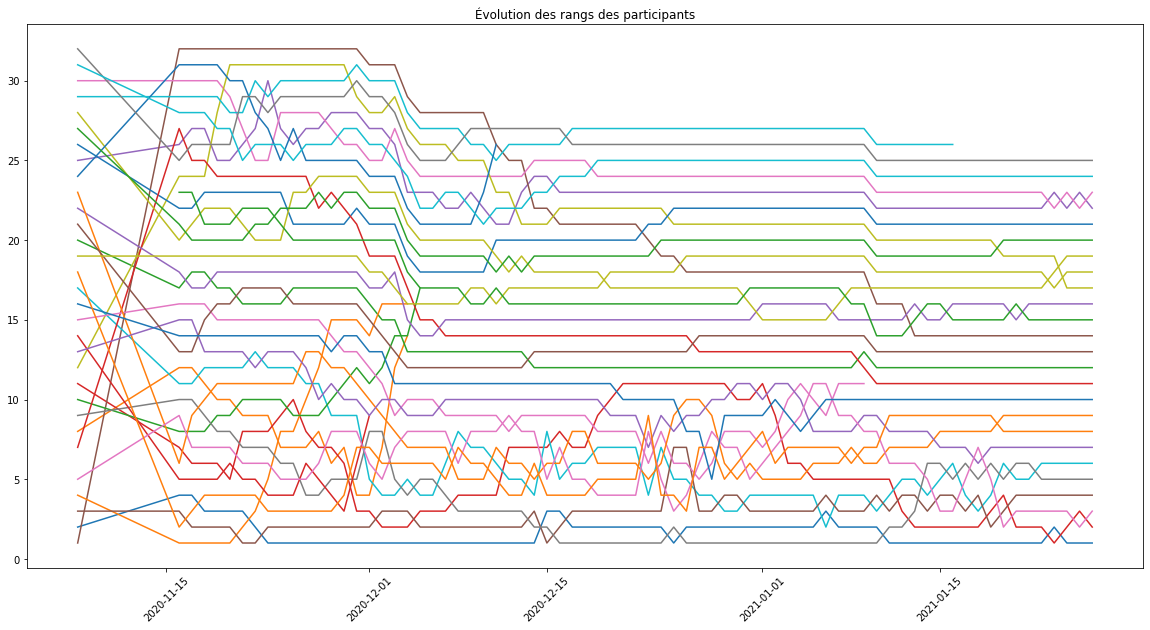

In [25]:
plt.figure(figsize=(20,10))
for voile in df_grouped["Voile"].unique():
    plt.plot(pd.to_datetime(df_grouped[df_grouped["Voile"]==voile]["DateTime"]).dt.date,df_grouped[df_grouped["Voile"]==voile]["Rang"])
plt.xticks(rotation=45)
plt.title("Évolution des rangs des participants")
plt.show()

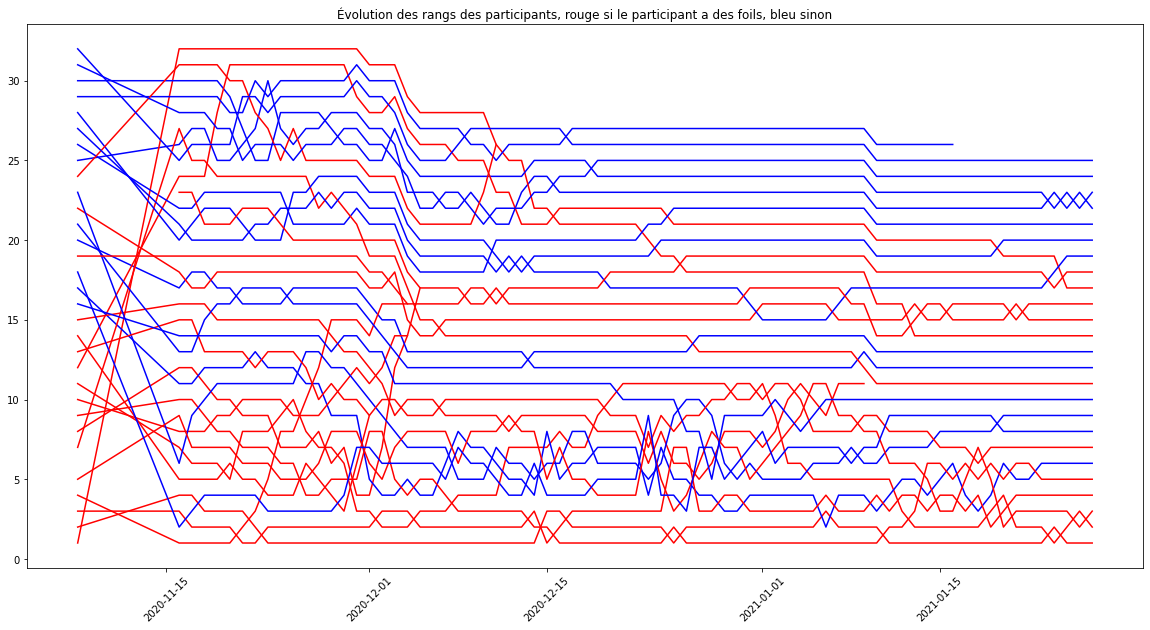

In [26]:
df_grouped["Voile"] = df_grouped["Voile"].astype(int)

plt.figure(figsize=(20,10))
cdict = {"foils":"r","no foils":"b"}
for voile in df_grouped["Voile"].unique():
    c = cdict[df_grouped[df_grouped["Voile"]==voile]["Foils"].tolist()[0]]
    plt.plot(pd.to_datetime(df_grouped[df_grouped["Voile"]==voile]["DateTime"]).dt.date,df_grouped[df_grouped["Voile"]==voile]["Rang"],c=c)
plt.xticks(rotation=45)
plt.title("Évolution des rangs des participants, rouge si le participant a des foils, bleu sinon")
plt.show()

## Conclusion des visualisations :

Les caractéristiques des navires, et en particulier la présence de foils, semblent avoir une influence sur le rang et la vitesse.

Le classement montre que les rangs se stabilisent assez rapidement et ne fluctuent par la suite que très peu, excepté dans le "peloton de tête". Cela se retrouve dans les figures plotly.

Le Machine Learning nous permettra de défintivement répondre à la question initiale.

# MACHINE LEARNING

Nous allons tenter de prédire la différence de rang (ie la progression ou la régression dans le classement) à l'aide de la vitesse depuis le dernier classement. Nous tenterons ensuite de rajouter d'autres "features" à nos modèles de régression, en particulier les caractéristiques des bateaux, afin d'évaluer l'impact du matériel sur la performance.

In [27]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

df_merged["Rangdiff"] = np.nan

for v in df_merged["Voile"].unique():
    mask = df_merged["Voile"]==v
    x = df_merged.loc[mask, :]
    x.iloc[0, -1] = 0
    for i in range(1, len(x)):
        x.iloc[i, -1] = x.iloc[i, 0] - x.iloc[i-1, 0]
    df_merged.loc[mask, :] = x

df_merged["Rangdiff"].isna().mean()

0.0

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import mean_squared_error as MSE, r2_score, roc_auc_score, confusion_matrix, classification_report

df_reg = df_merged#[df_merged["Rangdiff"] != 0]

features = ["classement_dist_nm","classement_vitesse_kts","classement_vmg_kts"]#,"Foils","Year_launched"]
target = ["Rangdiff"]

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13)

numeric_features = [0, 1, 2]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = [] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

first_models = []
for model in [LinearRegression(), SVR(), RandomForestRegressor()]:
    cv = cross_val_score(model, X_train, y_train, cv=5, )
    print(model, ":")
    print("R2: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    first_models.append(cv.mean())

LinearRegression() :
R2: 0.01 (+/- 0.00)
SVR() :
R2: -0.00 (+/- 0.01)
RandomForestRegressor() :
R2: -0.23 (+/- 0.47)


Première vague de modèle très peu performante... Excluons les lignes pour lesquelles il n'y a aucune progression, ie Rangdiff == 0.

In [29]:
df_reg = df_merged[df_merged["Rangdiff"] != 0]

features = ["classement_dist_nm","classement_vitesse_kts","classement_vmg_kts"]#,"Foils","Year_launched"]
target = ["Rangdiff"]

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13)

numeric_features = [0, 1, 2]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = [] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

second_models = []
for model in [LinearRegression(), SVR(), RandomForestRegressor()]:
    cv = cross_val_score(model, X_train, y_train, cv=5, )
    print(model, ":")
    print("R2: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    second_models.append(cv.mean())

LinearRegression() :
R2: 0.05 (+/- 0.08)
SVR() :
R2: 0.05 (+/- 0.08)
RandomForestRegressor() :
R2: 0.02 (+/- 0.34)


Un petit peu mieux, mais la part de la variance expliquée est toujours faible. Ajoutons des données liées aux bateaux.

In [30]:
df_reg = df_merged[df_merged["Rangdiff"] != 0]

features = ["classement_dist_nm","classement_vitesse_kts","classement_vmg_kts","Foils","Year_launched"]
target = ["Rangdiff"]

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13)

numeric_features = [0, 1, 2]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = [3, 4] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

third_models = []
for model in [LinearRegression(), SVR(), RandomForestRegressor()]:
    cv = cross_val_score(model, X_train, y_train, cv=5, )
    print(model, ":")
    print("R2: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    third_models.append(cv.mean())

LinearRegression() :
R2: -0.00 (+/- 0.10)
SVR() :
R2: 0.04 (+/- 0.07)
RandomForestRegressor() :
R2: 0.07 (+/- 0.26)


Toujours très médiocre. Voyons si nous précisons qui navigue.

In [31]:
df_reg = df_merged[(df_merged["Rangdiff"] != 0) & (df_merged["Skipper"] != "Nicolas Troussel")] #abandon très rapidement après le début

features = ["classement_dist_nm","classement_vitesse_kts","classement_vmg_kts","Foils","Year_launched","Skipper"]
target = ["Rangdiff"]

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13, stratify=X[:,5])

numeric_features = [0, 1, 2]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = [3, 4, 5] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

fourth_models = []
for model in [LinearRegression(), SVR(), RandomForestRegressor()]:
    cv = cross_val_score(model, X_train, y_train, cv=5)
    print(model, ":")
    print("R2: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    fourth_models.append(cv.mean())

LinearRegression() :
R2: -0.09 (+/- 0.12)
SVR() :
R2: -0.00 (+/- 0.07)
RandomForestRegressor() :
R2: -0.07 (+/- 0.41)


In [32]:
for i, scores in enumerate([first_models,second_models,third_models,fourth_models]):
    print(f"ML experiment {i+1}, score maximal :",np.max(scores))
    print(f"ML experiment {i+1}, score moyen :",np.mean(scores))

ML experiment 1, score maximal : 0.008328544645323888
ML experiment 1, score moyen : -0.07227257804253436
ML experiment 2, score maximal : 0.05473692253586278
ML experiment 2, score moyen : 0.041079224633101236
ML experiment 3, score maximal : 0.06603383132104138
ML experiment 3, score moyen : 0.035294488876337675
ML experiment 4, score maximal : -0.004308384494900519
ML experiment 4, score moyen : -0.05339372028871101


Décidément, très difficile de prévoir les variations du rang. Dernière intuition : prédire le signe de la variation du rang ! On passe à un problème de classification.

In [33]:
df_reg = df_merged[(df_merged["Rangdiff"] != 0)]# & (df_merged["Skipper"] != "Nicolas Troussel")] #abandon très rapidement après le début

features = ["classement_dist_nm","classement_vitesse_kts","classement_vmg_kts"]#,"Foils","Year_launched","Skipper"]
target = "Rangdiff"

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].apply(lambda x: 2 if x > 0 else 1 if x == 0 else 0)
display(y.value_counts()/len(y)) #Comparer à la distribution des classes pour voir si l'accuracy est supérieure à la classe la plus représentée
#ie faire mieux qu'un modèle qui prédit toujours la classe la plus représentée
y = y.values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13)#, stratify=X[:,5])

numeric_features = [0, 1, 2]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = []#3, 4, 5] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

fifth_models = []
for model in [LogisticRegression(), SVC(), RandomForestClassifier()]:
    cv = cross_val_score(model, X_train, y_train, cv=5)
    print(model, ":")
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    fifth_models.append(cv.mean())

0    0.541885
2    0.458115
Name: Rangdiff, dtype: float64

LogisticRegression() :
Accuracy: 0.65 (+/- 0.08)
SVC() :
Accuracy: 0.65 (+/- 0.07)
RandomForestClassifier() :
Accuracy: 0.63 (+/- 0.06)


On bat enfin le hasard en prédisant le signe de la différence de Rang à l'aide de la vitesse/distance depuis le dernier classement ! Rajoutons les données liées aux bateaux.

In [34]:
df_reg = df_merged[(df_merged["Rangdiff"] != 0)]# & (df_merged["Skipper"] != "Nicolas Troussel")] #abandon très rapidement après le début

features = ["classement_dist_nm","classement_vitesse_kts","classement_vmg_kts","Foils","Year_launched"]#,"Skipper"]
target = "Rangdiff"

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].apply(lambda x: 2 if x > 0 else 1 if x == 0 else 0)
display(y.value_counts()/len(y))
y = y.values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13)#, stratify=X[:,5])

numeric_features = [0, 1, 2]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = [3, 4]#, 5] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

sixth_models = []
for model in [LogisticRegression(), SVC(), RandomForestClassifier()]:
    cv = cross_val_score(model, X_train, y_train, cv=5)
    print(model, ":")
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    sixth_models.append(cv.mean())

0    0.541885
2    0.458115
Name: Rangdiff, dtype: float64

LogisticRegression() :
Accuracy: 0.65 (+/- 0.05)
SVC() :
Accuracy: 0.62 (+/- 0.06)
RandomForestClassifier() :
Accuracy: 0.62 (+/- 0.06)


Pas d'amélioration significative des scores. On ajoute le marin.

In [35]:
df_reg = df_merged[(df_merged["Rangdiff"] != 0) & (df_merged["Skipper"] != "Nicolas Troussel")] #abandon très rapidement après le début

features = ["classement_dist_nm","classement_vitesse_kts","classement_vmg_kts","Foils","Year_launched","Skipper"]
target = "Rangdiff"

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].apply(lambda x: 2 if x > 0 else 1 if x == 0 else 0)
display(y.value_counts()/len(y))
y = y.values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13, stratify=X[:,5])

numeric_features = [0, 1, 2]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = [3, 4, 5] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

seventh_models = []
for model in [LogisticRegression(), SVC(), RandomForestClassifier()]:
    cv = cross_val_score(model, X_train, y_train, cv=5)
    print(model, ":")
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    seventh_models.append(cv.mean())

0    0.541485
2    0.458515
Name: Rangdiff, dtype: float64

LogisticRegression() :
Accuracy: 0.64 (+/- 0.06)
SVC() :
Accuracy: 0.63 (+/- 0.07)
RandomForestClassifier() :
Accuracy: 0.62 (+/- 0.07)


Toujours pas d'amélioration significative des scores.

In [36]:
for i, scores in enumerate([fifth_models,sixth_models,seventh_models]):
    print(f"ML experiment {i+5}, score maximal :",np.max(scores))
    print(f"ML experiment {i+5}, score moyen :",np.mean(scores))

ML experiment 5, score maximal : 0.6509436954797778
ML experiment 5, score moyen : 0.6433958939113578
ML experiment 6, score maximal : 0.6457890563045202
ML experiment 6, score moyen : 0.6276641113754515
ML experiment 7, score maximal : 0.6412952683055776
ML experiment 7, score moyen : 0.6317049960348929


Dernière expérience : prédire le rang à l'arrivée à l'aide de ces variables. On travaillera sur `df_final`, créé plus tôt.

In [37]:
df_reg = df_final

features = ["SurlorthoVitesse","SurlorthoDistance","SurlefondVitesse","SurlefondDistance","distfond/distortho"]#,"Foils","Year_launched"]
target = ["Rang_arrivée"]

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13)

numeric_features = [0, 1, 2, 3, 4]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = []
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

eighth_models = []
for model in [LinearRegression(), SVR(), RandomForestRegressor()]:
    cv = cross_val_score(model, X_train, y_train, cv=5)
    print(model, ":")
    print("R2: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    eighth_models.append(cv.mean())

LinearRegression() :
R2: 0.85 (+/- 0.21)
SVR() :
R2: -0.02 (+/- 1.65)
RandomForestRegressor() :
R2: 0.79 (+/- 0.35)


La vitesse et la distance prédisent les variations de rang à l'arrivée... Améliorerons-nous le score en ajoutant des caractéristiques du bateau ?

In [38]:
df_reg = df_final

features = ["SurlorthoVitesse","SurlorthoDistance","SurlefondVitesse","SurlefondDistance","distfond/distortho","Foils","Year_launched"]
target = ["Rang_arrivée"]

X = df_reg.loc[:,features].values
y = df_reg.loc[:,target].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state=13)

numeric_features = [0, 1, 2, 3, 4, 6]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = [5] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

ninth_models = []
for model in [LinearRegression(), SVR(), RandomForestRegressor()]:
    cv = cross_val_score(model, X_train, y_train, cv=5)
    print(model, ":")
    print("R2: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    ninth_models.append(cv.mean())

LinearRegression() :
R2: 0.86 (+/- 0.21)
SVR() :
R2: -0.24 (+/- 2.36)
RandomForestRegressor() :
R2: 0.79 (+/- 0.37)


Pas d'amélioration significative des scores.

In [39]:
for i, scores in enumerate([eighth_models, ninth_models]):
    print(f"ML experiment {i+8}, score maximal :",np.max(scores))
    print(f"ML experiment {i+8}, score moyen :",np.mean(scores))

ML experiment 8, score maximal : 0.8519268465964597
ML experiment 8, score moyen : 0.5422973958864442
ML experiment 9, score maximal : 0.8567887956445442
ML experiment 9, score moyen : 0.4686841532212676


# TINTINTIN

En conclusion, nos modèles de machine learning nous poussent à conclure que ce sont les performances réelles du marin (distance parcourue soit capacité à naviguer au plus proche de l'ortho, vitesse moyenne soit capacité à naviguer vite) qui permettent de prédire son rang final et ses évolutions dans le classement, plutôt que les caractéristiques de son navire.

Bien que les visualisations montrent l'importance de certaines innovations (notamment les foils) vàv de la vitesse, certains compétiteurs s'en sortent très bien avec des navires moins sophistiqués (on pense au 4e, Jean LE CAM, qui navigue sur un bateau de 2007 sans foils), tandis que d'autres abandonnent bien qu'ayant des navires plus récents.

On se doute que c'est la combinaison du marin et de son vaisseau qui permettent de l'emporter, mais nos résultats nous poussent à croire que c'est d'abord le marin qui fait la performance plutôt que le bateau.